In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dateutil.relativedelta import relativedelta
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Step 2: Load and Preprocess Data

In [2]:
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)
df = df.drop(columns=['Series ID'])

# Keep only monthly data
df = df[df['Period'].str.startswith('M')]

# Convert 'Year' & 'Period' into a proper Date format
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01')

# Keep only relevant columns
df = df[['Date', 'Value']]
df.columns = ['timestamp', 'CPI']

# Set date as index
df = df.set_index('timestamp')

# Outlier Treatment
q1 = np.percentile(df['CPI'], 25)
q3 = np.percentile(df['CPI'], 75)
boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
df.loc[boolean_condition, 'CPI'] = np.mean(df['CPI'])


## Step 3: Holt-Winters Experiment

In [3]:
train_size = int(0.9 * df.shape[0])
HW_train = df.iloc[:train_size]
HW_test = df.iloc[train_size:]


## Train and Forecast Holt-Winters Model

In [4]:
# Fit Holt-Winters model
hw_model = ExponentialSmoothing(HW_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
hw_fit = hw_model.fit()

# Forecast
hw_forecast = hw_fit.forecast(steps=len(HW_test))


## Compute Performance Metrics

In [5]:
hw_rmse = np.sqrt(mean_squared_error(HW_test['CPI'], hw_forecast))
hw_mae = mean_absolute_error(HW_test['CPI'], hw_forecast)

print("Holt-Winters Performance:")
print(f"RMSE: {hw_rmse:.4f}")
print(f"MAE: {hw_mae:.4f}")


Holt-Winters Performance:
RMSE: 0.2868
MAE: 0.2130


## Plot Forecast vs Actual

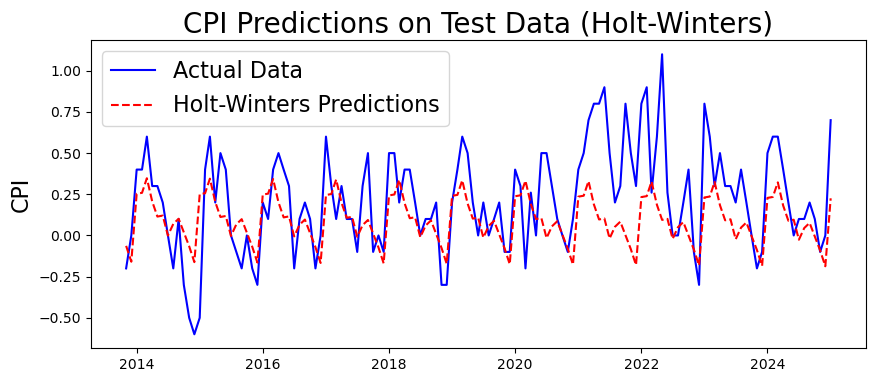

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(HW_test.index, HW_test['CPI'], label='Actual Data', color='blue')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Predictions', linestyle='--', color='red')
plt.legend(fontsize=16)
plt.title('CPI Predictions on Test Data (Holt-Winters)', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()




## Step 4: Holt-Winters Rolling Forecast

Rolling forecast for 2014-01-01 00:00:00: 0.27440473174752056
Rolling forecast for 2014-02-01 00:00:00: 0.3632930210243629
Rolling forecast for 2014-03-01 00:00:00: 0.22167038401474082
Rolling forecast for 2014-04-01 00:00:00: 0.12996395633043176
Rolling forecast for 2014-05-01 00:00:00: 0.1357915733884944
Rolling forecast for 2014-06-01 00:00:00: 0.014158671675816026
Rolling forecast for 2014-07-01 00:00:00: 0.08549816902600135
Rolling forecast for 2014-08-01 00:00:00: 0.1165067930056381
Rolling forecast for 2014-09-01 00:00:00: 0.01317237202038328
Rolling forecast for 2014-10-01 00:00:00: -0.058967554764747535
Rolling forecast for 2014-11-01 00:00:00: -0.1366822076533617
Rolling forecast for 2014-12-01 00:00:00: 0.27495556629778717
Rolling forecast for 2015-01-01 00:00:00: 0.27205292233762696
Rolling forecast for 2015-02-01 00:00:00: 0.3609404060567014
Rolling forecast for 2015-03-01 00:00:00: 0.21932406569266744
Rolling forecast for 2015-04-01 00:00:00: 0.12761962680140587
Rolling f

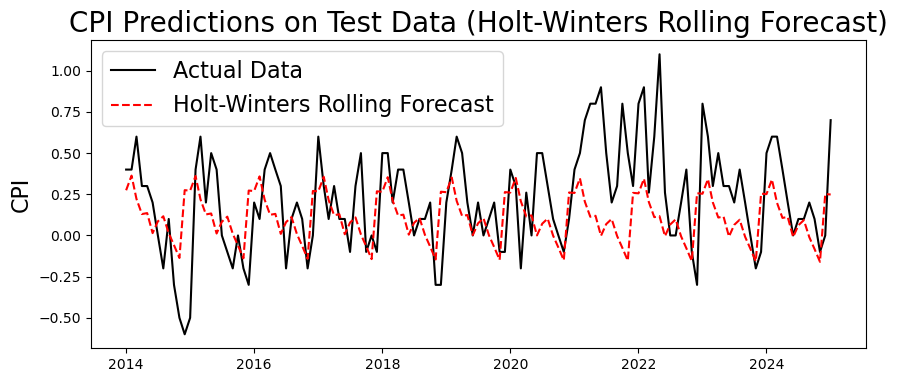

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Set rolling forecast start and end times
start_time = datetime(1913, 1, 1)
end_time = datetime(2014, 1, 1)

roll_end_time = end_time
HW_roll_train = df.loc[:end_time].copy()  # Copy data until end_time

# List to store rolling predictions
rolling_forecast = []

# Rolling forecast loop
while roll_end_time in df.index:  # Ensure roll_end_time exists in dataset
    # Select current rolling test point
    HW_roll_test = df.loc[roll_end_time:roll_end_time]

    # Train Holt-Winters model on rolling training set
    HW_roll_model = ExponentialSmoothing(HW_roll_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
    HW_roll_model_fit = HW_roll_model.fit()

    # Forecast next step
    HW_roll_predictions = HW_roll_model_fit.forecast(steps=1)

    # Store forecasted values
    rolling_forecast.append((roll_end_time, float(HW_roll_predictions)))

    # Print rolling forecast progress
    print(f"Rolling forecast for {roll_end_time}: {float(HW_roll_predictions)}")

    # Move to next month
    roll_end_time = roll_end_time + relativedelta(months=+1)

    # Append the prediction to the rolling training set
    new_entry = pd.DataFrame({'CPI': [float(HW_roll_predictions)]}, index=[roll_end_time])
    HW_roll_train = pd.concat([HW_roll_train, new_entry])

# Convert rolling forecast list to DataFrame
HW_rolling_results = pd.DataFrame(rolling_forecast, columns=['timestamp', 'CPI']).set_index('timestamp')

# Plot Rolling Forecast Results
plt.figure(figsize=(10, 4))
plt.plot(df.loc[end_time:], label="Actual Data", color="black")
plt.plot(HW_rolling_results.index, HW_rolling_results['CPI'], label="Holt-Winters Rolling Forecast", linestyle="--", color="red")
plt.legend(fontsize=16)
plt.title("CPI Predictions on Test Data (Holt-Winters Rolling Forecast)", fontsize=20)
plt.ylabel("CPI", fontsize=16)
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure rolling test data is correctly indexed
HW_test_rolling = df.loc[end_time:].copy()

# Find common dates
common_dates = HW_rolling_results.index.intersection(HW_test_rolling.index)

# Extract matching values
rolling_actuals = HW_test_rolling.loc[common_dates, 'CPI']
rolling_predictions = HW_rolling_results.loc[common_dates, 'CPI']

# Compute RMSE and MAE
hw_rolling_rmse = np.sqrt(mean_squared_error(rolling_actuals, rolling_predictions))
hw_rolling_mae = mean_absolute_error(rolling_actuals, rolling_predictions)

print("📊 Holt-Winters Rolling Forecast Performance:")
print(f"✅ RMSE: {hw_rolling_rmse:.4f}")
print(f"✅ MAE: {hw_rolling_mae:.4f}")


📊 Holt-Winters Rolling Forecast Performance:
✅ RMSE: 0.3211
✅ MAE: 0.2464


In [17]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Ensure df is defined from the existing script
if 'df' not in locals():
    raise ValueError("The dataset 'df' is not defined. Please provide a DataFrame with CPI time series data.")

# Define the forecast start date
forecast_start_date = datetime(2025, 2, 1)
forecast_end_dates = [forecast_start_date + relativedelta(months=i) for i in range(12)]

# --- 1. Holt-Winters Standard Forecast --- #
hw_model = ExponentialSmoothing(df['CPI'], seasonal_periods=12, trend='add', seasonal='add')
hw_model_fit = hw_model.fit()

# Generate next 6-month forecast
hw_forecast = hw_model_fit.forecast(steps=6)

# Create DataFrame for Holt-Winters standard forecast
hw_forecast_df = pd.DataFrame({'Date': forecast_end_dates, 'CPI_Forecast': hw_forecast.values})

# --- 2. Holt-Winters Rolling Forecast --- #
roll_end_time = forecast_start_date - relativedelta(months=1)
hw_roll_forecast_dates = []
hw_roll_forecast_values = []
hw_roll_train = df.copy()

for _ in range(6):
    hw_roll_model = ExponentialSmoothing(hw_roll_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
    hw_roll_model_fit = hw_roll_model.fit()

    hw_roll_prediction = hw_roll_model_fit.forecast(steps=1).iloc[-1]

    hw_roll_forecast_dates.append(roll_end_time + relativedelta(months=1))
    hw_roll_forecast_values.append(float(hw_roll_prediction))

    # Update training data with forecasted value
    hw_roll_train.loc[roll_end_time + relativedelta(months=1)] = float(hw_roll_prediction)
    roll_end_time += relativedelta(months=1)

# Create DataFrame for rolling forecast
hw_roll_forecast_df = pd.DataFrame({'Date': hw_roll_forecast_dates, 'CPI_Forecast': hw_roll_forecast_values})

# Save forecasts to Excel files
hw_output_file = "CPI_Forecast_HoltzWinters_Next_6_Months.xlsx"
hw_roll_output_file = "CPI_Forecast_HoltzWinters_Rolling_Next_6_Months.xlsx"

hw_forecast_df.to_excel(hw_output_file, index=False)
hw_roll_forecast_df.to_excel(hw_roll_output_file, index=False)

# --- Plotting Results --- #
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(hw_forecast_df['Date'], hw_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Holt-Winters Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 6 Months (Holt-Winters)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(hw_roll_forecast_df['Date'], hw_roll_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Holt-Winters Rolling Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 6 Months (Holt-Winters Rolling)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()




ValueError: All arrays must be of the same length

In [14]:
hw_roll_forecast_df.head(10)

,Date,CPI_Forecast
0,2025-02-01,0.467004
1,2025-03-01,0.452900
2,2025-04-01,0.422606
3,2025-05-01,0.349420
4,2025-06-01,0.287225
5,2025-07-01,0.144780


In [16]:
hw_forecast_df.head(10)

,Date,CPI_Forecast
0,2025-02-01,0.467004
1,2025-03-01,0.452900
2,2025-04-01,0.422606
3,2025-05-01,0.349420
4,2025-06-01,0.287224
5,2025-07-01,0.144780


In [ ]:
# Return saved file paths
hw_output_file, hw_roll_output_file

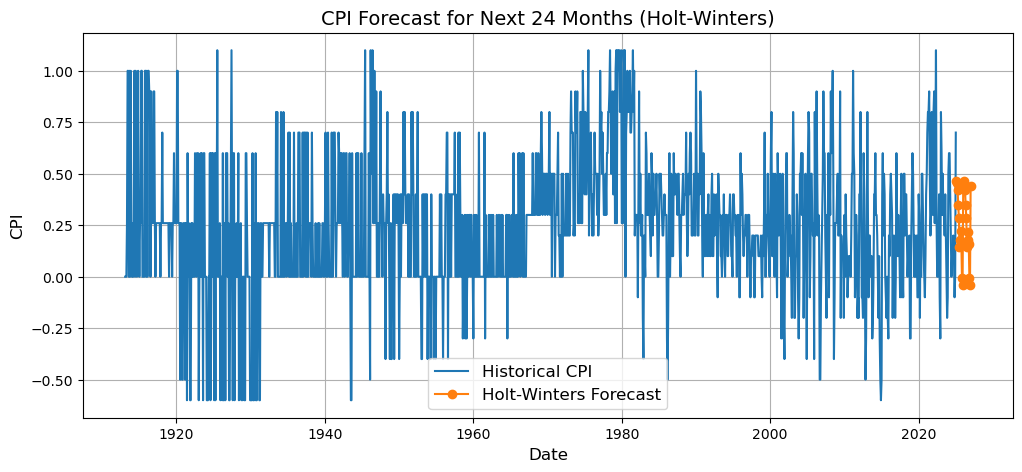

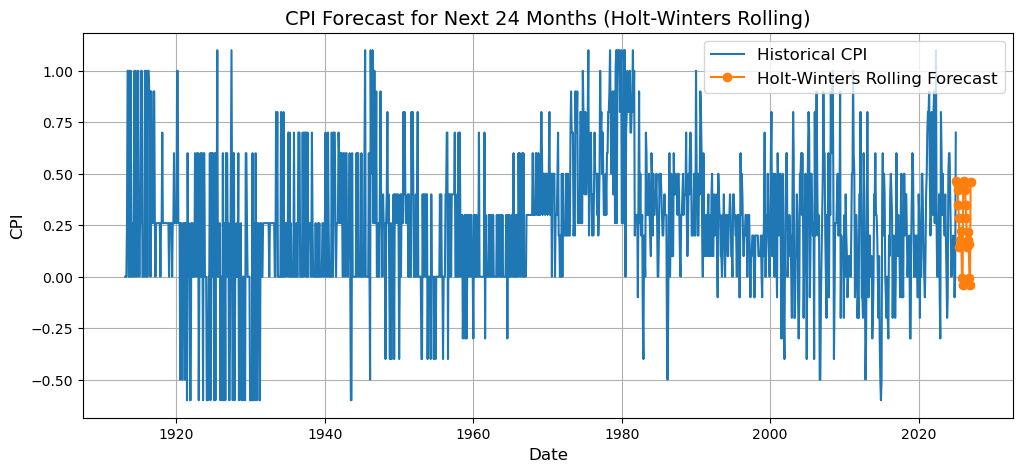

In [19]:
# Define the forecast start date for 24 months
forecast_start_date = datetime(2025, 2, 1)
forecast_end_dates = [forecast_start_date + relativedelta(months=i) for i in range(24)]

# --- 1. Holt-Winters Standard Forecast --- #
hw_model = ExponentialSmoothing(df['CPI'], seasonal_periods=12, trend='add', seasonal='add')
hw_model_fit = hw_model.fit()

# Generate next 24-month forecast
hw_forecast = hw_model_fit.forecast(steps=24)

# Create DataFrame for Holt-Winters standard forecast
hw_forecast_df = pd.DataFrame({'Date': forecast_end_dates, 'CPI_Forecast': hw_forecast.values})

# --- 2. Holt-Winters Rolling Forecast --- #
roll_end_time = forecast_start_date - relativedelta(months=1)
hw_roll_forecast_dates = []
hw_roll_forecast_values = []
hw_roll_train = df.copy()

for _ in range(24):
    hw_roll_model = ExponentialSmoothing(hw_roll_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
    hw_roll_model_fit = hw_roll_model.fit()

    hw_roll_prediction = hw_roll_model_fit.forecast(steps=1).iloc[-1]

    hw_roll_forecast_dates.append(roll_end_time + relativedelta(months=1))
    hw_roll_forecast_values.append(float(hw_roll_prediction))

    # Update training data with forecasted value
    hw_roll_train.loc[roll_end_time + relativedelta(months=1)] = float(hw_roll_prediction)
    roll_end_time += relativedelta(months=1)

# Create DataFrame for rolling forecast
hw_roll_forecast_df = pd.DataFrame({'Date': hw_roll_forecast_dates, 'CPI_Forecast': hw_roll_forecast_values})

# Save forecasts to Excel files
hw_output_file = "CPI_Forecast_HoltzWinters_Next_24_Months.xlsx"
hw_roll_output_file = "CPI_Forecast_HoltzWinters_Rolling_Next_24_Months.xlsx"

hw_forecast_df.to_excel(hw_output_file, index=False)
hw_roll_forecast_df.to_excel(hw_roll_output_file, index=False)

# --- Plotting Results --- #
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(hw_forecast_df['Date'], hw_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Holt-Winters Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 24 Months (Holt-Winters)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(hw_roll_forecast_df['Date'], hw_roll_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Holt-Winters Rolling Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 24 Months (Holt-Winters Rolling)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

# # Return saved file paths
# hw_output_file, hw_roll_output_file


In [20]:
hw_roll_forecast_df.head(30)

,Date,CPI_Forecast
0,2025-02-01,0.467004
1,2025-03-01,0.452900
2,2025-04-01,0.422606
3,2025-05-01,0.349420
4,2025-06-01,0.287225
5,2025-07-01,0.144780
6,2025-08-01,0.180264
7,2025-09-01,0.220203
8,2025-10-01,0.159746
9,2025-11-01,-0.005169


In [21]:
hw_forecast_df.head(30)

,Date,CPI_Forecast
0,2025-02-01,0.467004
1,2025-03-01,0.452900
2,2025-04-01,0.422606
3,2025-05-01,0.349420
4,2025-06-01,0.287224
5,2025-07-01,0.144780
6,2025-08-01,0.180264
7,2025-09-01,0.220203
8,2025-10-01,0.159746
9,2025-11-01,-0.005170


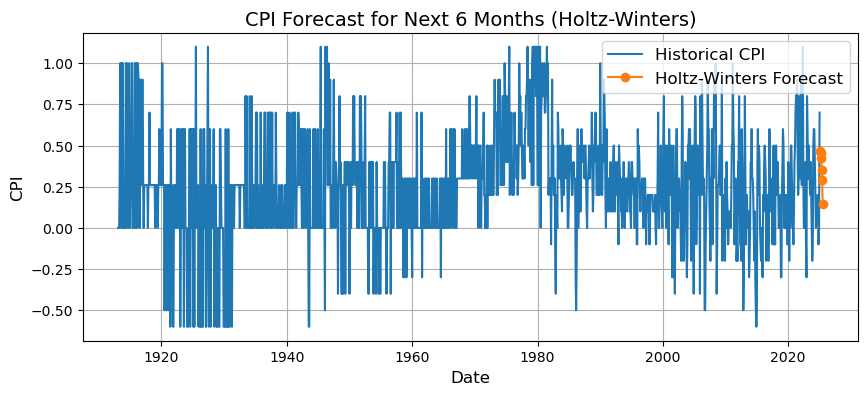

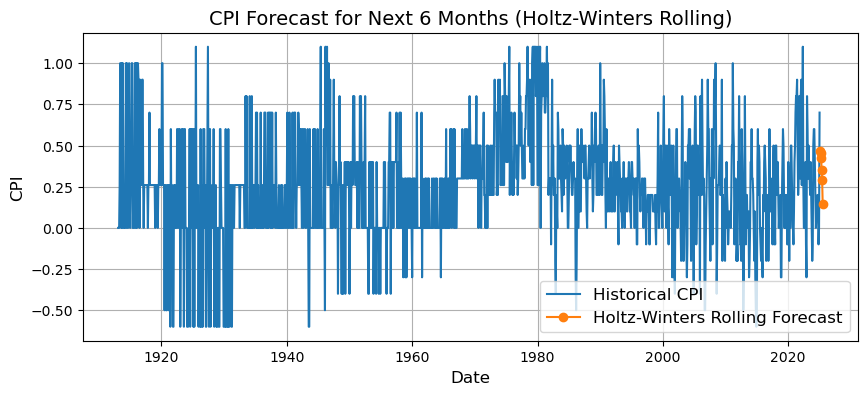

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# # Ensure df is defined from the notebook extraction
# if 'df' not in locals():
#     raise ValueError("The dataset 'df' is not defined. Please provide a DataFrame with CPI time series data.")

# # Define the last available date in the dataset
# end_time = df.index[-1]

# # --- 1. Holtz-Winters Standard Forecast --- #
# hw_model = ExponentialSmoothing(df['CPI'], seasonal='add', seasonal_periods=12)
# hw_model_fit = hw_model.fit()

# # Generate next 6-month forecast
# future_dates = [end_time + relativedelta(months=i) for i in range(1, 7)]
# hw_forecast = hw_model_fit.forecast(steps=6)

# # Create a DataFrame for forecasted values
# hw_forecast_df = pd.DataFrame({'Date': future_dates, 'CPI_Forecast': hw_forecast.values})

# # --- 2. Holtz-Winters Rolling Forecast --- #
# roll_end_time = end_time
# hw_roll_forecast_dates = []
# hw_roll_forecast_values = []
# hw_roll_train = df.copy()

# for _ in range(6):
#     hw_roll_model = ExponentialSmoothing(hw_roll_train['CPI'], seasonal='add', seasonal_periods=12)
#     hw_roll_model_fit = hw_roll_model.fit()

#     hw_roll_prediction = hw_roll_model_fit.forecast(steps=1).iloc[-1]

#     hw_roll_forecast_dates.append(roll_end_time + relativedelta(months=1))
#     hw_roll_forecast_values.append(float(hw_roll_prediction))

#     # Update training data with forecasted value
#     hw_roll_train.loc[roll_end_time + relativedelta(months=1)] = float(hw_roll_prediction)
#     roll_end_time += relativedelta(months=1)

# # Create DataFrame for rolling forecast
# hw_roll_forecast_df = pd.DataFrame({'Date': hw_roll_forecast_dates, 'CPI_Forecast': hw_roll_forecast_values})

# # Save forecasts to Excel files
# hw_output_file = "CPI_Forecast_HoltzWinters_Next_6_Months.xlsx"
# hw_roll_output_file = "CPI_Forecast_HoltzWinters_Rolling_Next_6_Months.xlsx"

# hw_forecast_df.to_excel(hw_output_file, index=False)
# hw_roll_forecast_df.to_excel(hw_roll_output_file, index=False)

# # --- Plotting Results --- #
# plt.figure(figsize=(10, 4))
# plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
# plt.plot(hw_forecast_df['Date'], hw_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Holtz-Winters Forecast")
# plt.legend(fontsize=12)
# plt.title('CPI Forecast for Next 6 Months (Holtz-Winters)', fontsize=14)
# plt.ylabel('CPI', fontsize=12)
# plt.xlabel('Date', fontsize=12)
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 4))
# plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
# plt.plot(hw_roll_forecast_df['Date'], hw_roll_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Holtz-Winters Rolling Forecast")
# plt.legend(fontsize=12)
# plt.title('CPI Forecast for Next 6 Months (Holtz-Winters Rolling)', fontsize=14)
# plt.ylabel('CPI', fontsize=12)
# plt.xlabel('Date', fontsize=12)
# plt.grid(True)
# plt.show()




In [ ]:
# Return saved file paths
hw_output_file, hw_roll_output_file

In [11]:
hw_roll_forecast_df.head(10)

,Date,CPI_Forecast
0,2025-02-01,0.467754
1,2025-03-01,0.453715
2,2025-04-01,0.423487
3,2025-05-01,0.350367
4,2025-06-01,0.288236
5,2025-07-01,0.145857


In [12]:
hw_forecast_df.head(10)

,Date,CPI_Forecast
0,2025-02-01,0.467754
1,2025-03-01,0.453715
2,2025-04-01,0.423486
3,2025-05-01,0.350367
4,2025-06-01,0.288236
5,2025-07-01,0.145857
